In [18]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline


Let's train the model again first - to use its results later in this notebook

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [20]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(0)

df.columns = df.columns.str.lower().str.replace(' ', '_')

string_columns = list(df.dtypes[df.dtypes == 'object'].index)

for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')

df.churn = (df.churn == 'yes').astype(int)

In [21]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.33, random_state=11)

y_train = df_train.churn.values
y_val = df_val.churn.values

del df_train['churn']
del df_val['churn']

In [22]:
categorical = ['gender', 'seniorcitizen', 'partner', 'dependents',
               'phoneservice', 'multiplelines', 'internetservice',
               'onlinesecurity', 'onlinebackup', 'deviceprotection',
               'techsupport', 'streamingtv', 'streamingmovies',
               'contract', 'paperlessbilling', 'paymentmethod']
numerical = ['tenure', 'monthlycharges', 'totalcharges']

In [23]:
train_dict = df_train[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

X_train = dv.transform(train_dict)

In [24]:
model = LogisticRegression(solver='liblinear', random_state=1)
model.fit(X_train, y_train)

LogisticRegression(random_state=1, solver='liblinear')

In [25]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)
y_pred = model.predict_proba(X_val)[:, 1]

In [26]:
small_subset = ['contract', 'tenure', 'totalcharges']
train_dict_small = df_train[small_subset].to_dict(orient='records')
dv_small = DictVectorizer(sparse=False)
dv_small.fit(train_dict_small)

X_small_train = dv_small.transform(train_dict_small)

model_small = LogisticRegression(solver='liblinear', random_state=1)
model_small.fit(X_small_train, y_train)

LogisticRegression(random_state=1, solver='liblinear')

In [27]:
val_dict_small = df_val[small_subset].to_dict(orient='records')
X_small_val = dv_small.transform(val_dict_small)

y_pred_small = model_small.predict_proba(X_small_val)[:, 1]

## Accuracy

In [28]:
y_pred = model.predict_proba(X_val)[:, 1]
churn = y_pred >= 0.5
(churn == y_val).mean()

np.float64(0.8016129032258065)

In [29]:
from sklearn.metrics import accuracy_score

In [30]:
accuracy_score(y_val, y_pred >= 0.5)

0.8016129032258065

In [31]:
thresholds = np.linspace(0, 1, 11)
thresholds

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [32]:
thresholds = np.linspace(0, 1, 21)

accuracies = []

for t in thresholds:
    acc = accuracy_score(y_val, y_pred >= t)
    accuracies.append(acc)
    print('%0.2f %0.3f' % (t, acc))

0.00 0.261
0.05 0.501
0.10 0.595
0.15 0.640
0.20 0.690
0.25 0.730
0.30 0.755
0.35 0.767
0.40 0.782
0.45 0.795
0.50 0.802
0.55 0.790
0.60 0.790
0.65 0.788
0.70 0.774
0.75 0.752
0.80 0.742
0.85 0.739
0.90 0.739
0.95 0.739
1.00 0.739


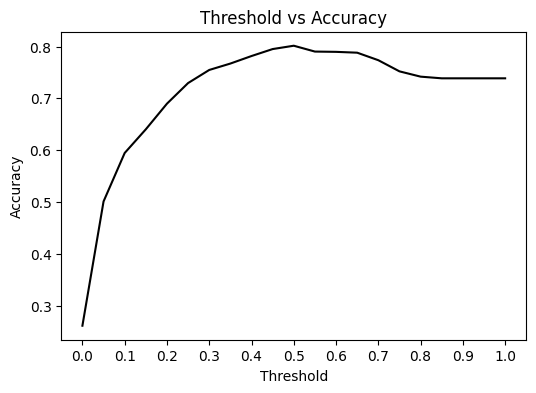

In [33]:
plt.figure(figsize=(6, 4))

plt.plot(thresholds, accuracies, color='black')

plt.title('Threshold vs Accuracy')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')

plt.xticks(np.linspace(0, 1, 11))

# plt.savefig('04_threshold_accuracy.svg')

plt.show()

In [34]:
churn_small = y_pred_small >= 0.5
(churn_small == y_val).mean()

np.float64(0.7672043010752688)

In [35]:
accuracy_score(y_val, churn_small)

0.7672043010752688

In [36]:
size_val = len(y_val)
baseline = np.repeat(False, size_val)
baseline

array([False, False, False, ..., False, False, False])

In [37]:
accuracy_score(baseline, y_val)

0.7387096774193549

In [38]:
!pip install seaborn


In [39]:
!python.exe -m pip install --upgrade pip

## Confusion table

In [40]:
true_positive = ((y_pred >= 0.5) & (y_val == 1)).sum()
false_positive = ((y_pred >= 0.5) & (y_val == 0)).sum()
false_negative = ((y_pred < 0.5) & (y_val == 1)).sum()
true_negative = ((y_pred < 0.5) & (y_val == 0)).sum()

In [41]:
confusion_table = np.array(
     # predict neg    pos
    [[true_negative, false_positive], # actual neg
     [false_negative, true_positive]]) # actual pos

confusion_table

array([[1202,  172],
       [ 197,  289]])

In [42]:
confusion_table / confusion_table.sum()

array([[0.64623656, 0.09247312],
       [0.10591398, 0.15537634]])

## Precision and recall

In [43]:
precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)
precision, recall

(np.float64(0.6268980477223427), np.float64(0.5946502057613169))

In [44]:
confusion_table / confusion_table.sum()

array([[0.64623656, 0.09247312],
       [0.10591398, 0.15537634]])

In [45]:
precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)
precision, recall

(np.float64(0.6268980477223427), np.float64(0.5946502057613169))

## ROC and AUC

TPR and FPR

In [46]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds: #B
    tp = ((y_pred >= t) & (y_val == 1)).sum()
    fp = ((y_pred >= t) & (y_val == 0)).sum()
    fn = ((y_pred < t) & (y_val == 1)).sum()
    tn = ((y_pred < t) & (y_val == 0)).sum()
    scores.append((t, tp, fp, fn, tn))

df_scores = pd.DataFrame(scores)
df_scores.columns = ['threshold', 'tp', 'fp', 'fn', 'tn']

In [47]:
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,486,1374,0,0
10,0.1,458,726,28,648
20,0.2,421,512,65,862
30,0.3,380,350,106,1024
40,0.4,337,257,149,1117
50,0.5,289,172,197,1202
60,0.6,200,105,286,1269
70,0.7,99,34,387,1340
80,0.8,7,1,479,1373
90,0.9,0,0,486,1374


In [48]:
df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

In [49]:
df_scores[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,486,1374,0,0,1.000000,1.000000
10,0.1,458,726,28,648,0.942387,0.528384
20,0.2,421,512,65,862,0.866255,0.372635
30,0.3,380,350,106,1024,0.781893,0.254731
40,0.4,337,257,149,1117,0.693416,0.187045
50,0.5,289,172,197,1202,0.594650,0.125182
60,0.6,200,105,286,1269,0.411523,0.076419
70,0.7,99,34,387,1340,0.203704,0.024745
80,0.8,7,1,479,1373,0.014403,0.000728
90,0.9,0,0,486,1374,0.000000,0.000000


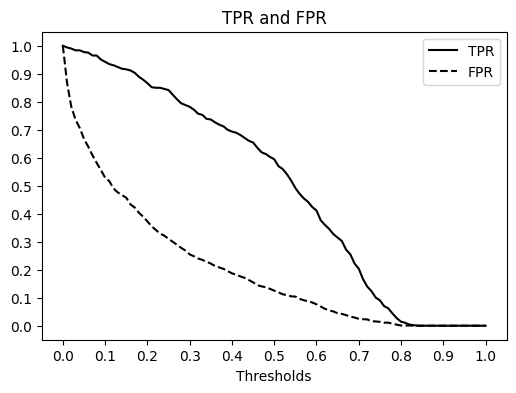

In [50]:
plt.figure(figsize=(6, 4))

plt.plot(df_scores.threshold, df_scores.tpr, color='black', linestyle='solid', label='TPR')
plt.plot(df_scores.threshold, df_scores.fpr, color='black', linestyle='dashed', label='FPR')
plt.legend()

plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))

plt.xlabel('Thresholds')
plt.title('TPR and FPR')

# plt.savefig('04_fpr_tpr_plot.svg')

plt.show()

Random baseline

In [51]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        tp = ((y_pred >= t) & (y_val == 1)).sum()
        fp = ((y_pred >= t) & (y_val == 0)).sum()
        fn = ((y_pred < t) & (y_val == 1)).sum()
        tn = ((y_pred < t) & (y_val == 0)).sum()

        scores.append((t, tp, fp, fn, tn))

    df_scores = pd.DataFrame(scores)
    df_scores.columns = ['threshold', 'tp', 'fp', 'fn', 'tn']

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

    return df_scores

In [52]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))
df_rand = tpr_fpr_dataframe(y_val, y_rand)
df_rand[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,486,1374,0,0,1.000000,1.000000
10,0.1,440,1236,46,138,0.905350,0.899563
20,0.2,392,1101,94,273,0.806584,0.801310
30,0.3,339,972,147,402,0.697531,0.707424
40,0.4,288,849,198,525,0.592593,0.617904
50,0.5,239,723,247,651,0.491770,0.526201
60,0.6,193,579,293,795,0.397119,0.421397
70,0.7,152,422,334,952,0.312757,0.307132
80,0.8,98,302,388,1072,0.201646,0.219796
90,0.9,57,147,429,1227,0.117284,0.106987


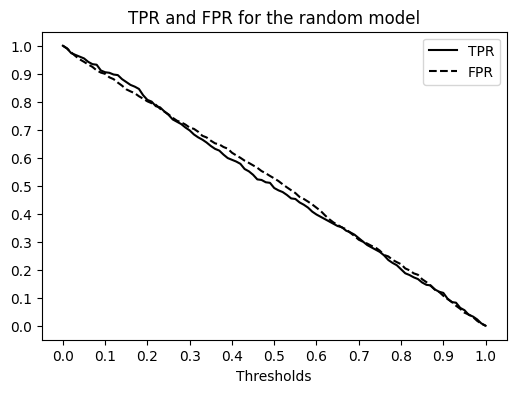

In [53]:
plt.figure(figsize=(6, 4))

plt.plot(df_rand.threshold, df_rand.tpr, color='black', linestyle='solid', label='TPR')
plt.plot(df_rand.threshold, df_rand.fpr, color='black', linestyle='dashed', label='FPR')
plt.legend()

plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))

plt.xlabel('Thresholds')
plt.title('TPR and FPR for the random model')

#plt.savefig('04_fpr_tpr_plot_random.svg')

plt.show()

Ideal baseline:

In [54]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()

y_ideal = np.repeat([0, 1], [num_neg, num_pos])
y_pred_ideal = np.linspace(0, 1, num_neg + num_pos)

df_ideal = tpr_fpr_dataframe(y_ideal, y_pred_ideal)
df_ideal[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,486,1374,0,0,1.000000,1.000000
10,0.1,486,1188,0,186,1.000000,0.864629
20,0.2,486,1002,0,372,1.000000,0.729258
30,0.3,486,816,0,558,1.000000,0.593886
40,0.4,486,630,0,744,1.000000,0.458515
50,0.5,486,444,0,930,1.000000,0.323144
60,0.6,486,258,0,1116,1.000000,0.187773
70,0.7,486,72,0,1302,1.000000,0.052402
80,0.8,372,0,114,1374,0.765432,0.000000
90,0.9,186,0,300,1374,0.382716,0.000000


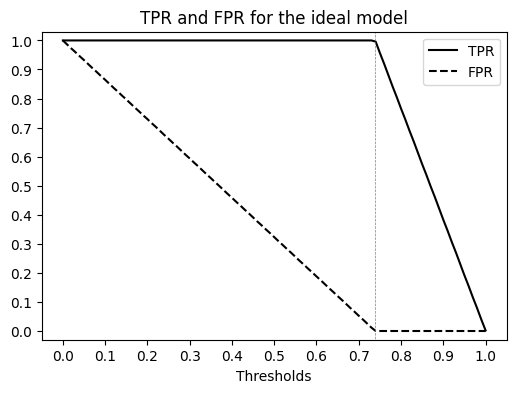

In [55]:
plt.figure(figsize=(6, 4))

plt.plot(df_ideal.threshold, df_ideal.tpr, color='black', linestyle='solid', label='TPR')
plt.plot(df_ideal.threshold, df_ideal.fpr, color='black', linestyle='dashed', label='FPR')
plt.legend()

plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))

plt.vlines(1 - y_val.mean(), -1, 2, linewidth=0.5, linestyle='dashed', color='grey')
plt.ylim(-0.03, 1.03)

plt.xlabel('Thresholds')
plt.title('TPR and FPR for the ideal model')

# plt.savefig('04_fpr_tpr_plot_ideal.svg')

plt.show()

ROC curve

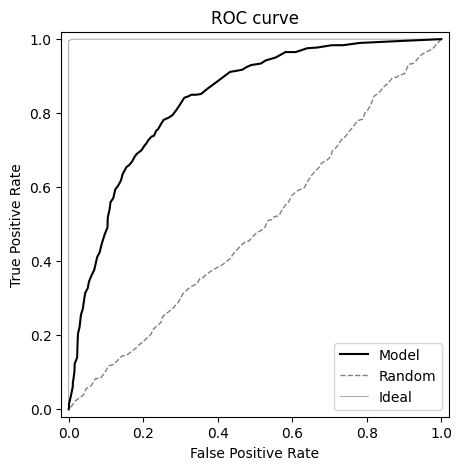

In [56]:
plt.figure(figsize=(5, 5))

plt.plot(df_scores.fpr, df_scores.tpr, color='black', label='Model')
plt.plot(df_rand.fpr, df_rand.tpr, color='black', lw=1,
         linestyle='dashed', alpha=0.5, label='Random')
plt.plot(df_ideal.fpr, df_ideal.tpr, color='black', lw=0.5,
         linestyle='solid', alpha=0.5, label='Ideal')

plt.legend()

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC curve')

# plt.savefig('04_roc_curve_with_baselines.svg')

plt.show()

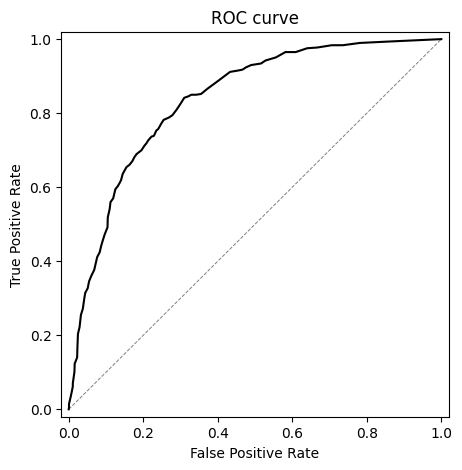

In [57]:
plt.figure(figsize=(5, 5))

plt.plot(df_scores.fpr, df_scores.tpr, color='black')
plt.plot([0, 1], [0, 1], color='black', lw=0.7, linestyle='dashed', alpha=0.5)

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC curve')

# plt.savefig('04_roc_curve.svg')

plt.show()

Using Scikit-Learn for plotting the ROC curve

In [58]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [59]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

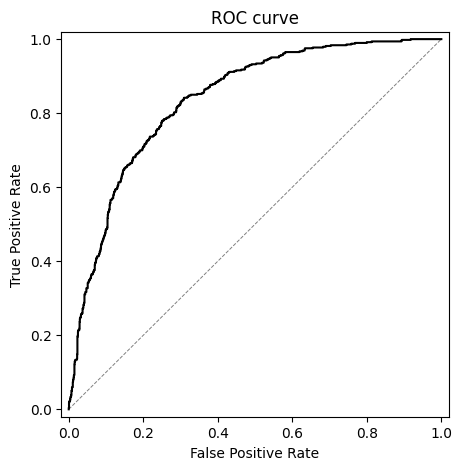

In [60]:
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, color='black')
plt.plot([0, 1], [0, 1], color='black', lw=0.7, linestyle='dashed', alpha=0.5)

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC curve')

plt.show()

AUC: Area under the ROC curve

In [61]:
df_scores_small = tpr_fpr_dataframe(y_val, y_pred_small)

In [62]:
auc(df_scores.fpr, df_scores.tpr)

np.float64(0.8359001084215382)

In [63]:
auc(df_scores_small.fpr, df_scores_small.tpr)

np.float64(0.8108718050089552)

Comparing multiple models with ROC curves

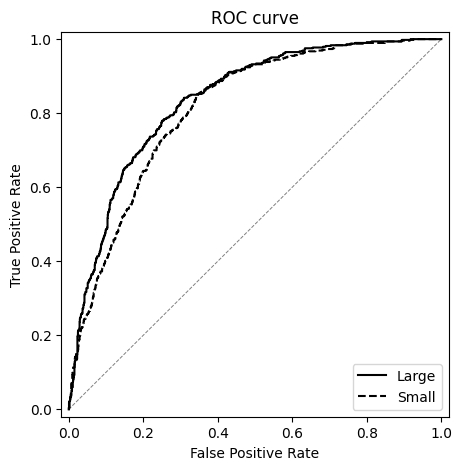

In [64]:
fpr_large, tpr_large, _ = roc_curve(y_val, y_pred)
fpr_small, tpr_small, _ = roc_curve(y_val, y_pred_small)

plt.figure(figsize=(5, 5))

plt.plot(fpr_large, tpr_large, color='black', linestyle='solid', label='Large')
plt.plot(fpr_small, tpr_small, color='black', linestyle='dashed', label='Small')
plt.plot([0, 1], [0, 1], color='black', lw=0.7, linestyle='dashed', alpha=0.5)

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC curve')
plt.legend(loc='lower right')

plt.show()

In [65]:
from sklearn.metrics import roc_auc_score

In [66]:
roc_auc_score(y_val, y_pred)

np.float64(0.8363396349608545)

In [67]:
roc_auc_score(y_val, y_pred_small)

np.float64(0.8117942866042492)

Interpretation of AUC: the probability that a randomly chosen positive example
ranks higher than a randomly chosen negative example

In [68]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

np.random.seed(1)
neg_choice = np.random.randint(low=0, high=len(neg), size=10000)
pos_choice = np.random.randint(low=0, high=len(pos), size=10000)
(pos[pos_choice] > neg[neg_choice]).mean()

np.float64(0.8356)

## K-fold cross-validation

In [69]:
def train(df, y):
    cat = df[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    dv.fit(cat)

    X = dv.transform(cat)

    model = LogisticRegression(solver='liblinear')
    model.fit(X, y)

    return dv, model


def predict(df, dv, model):
    cat = df[categorical + numerical].to_dict(orient='records')
    
    X = dv.transform(cat)

    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [70]:
from sklearn.model_selection import KFold

In [71]:
kfold = KFold(n_splits=10, shuffle=True, random_state=1)

In [72]:
aucs = []

for train_idx, val_idx in kfold.split(df_train_full):
    df_train = df_train_full.iloc[train_idx]
    y_train = df_train.churn.values

    df_val = df_train_full.iloc[val_idx]
    y_val = df_val.churn.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    rocauc = roc_auc_score(y_val, y_pred)
    aucs.append(rocauc)

In [73]:
np.array(aucs).round(3)

array([0.849, 0.841, 0.859, 0.833, 0.824, 0.841, 0.844, 0.824, 0.845,
       0.861])

In [74]:
print('auc = %0.3f ± %0.3f' % (np.mean(aucs), np.std(aucs)))

auc = 0.842 ± 0.012


Tuning the parameter `C`

In [75]:
def train(df, y, C=1.0):
    cat = df[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    dv.fit(cat)

    X = dv.transform(cat)

    model = LogisticRegression(solver='liblinear', C=C)
    model.fit(X, y)

    return dv, model

In [76]:
nfolds = 5
kfold = KFold(n_splits=nfolds, shuffle=True, random_state=1)

for C in [0.001, 0.01, 0.1, 0.5, 1, 10]:
    aucs = []

    for train_idx, val_idx in kfold.split(df_train_full):
        df_train = df_train_full.iloc[train_idx]
        df_val = df_train_full.iloc[val_idx]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
        
        auc = roc_auc_score(y_val, y_pred)
        aucs.append(auc)

    print('C=%s, auc = %0.3f ± %0.3f' % (C, np.mean(aucs), np.std(aucs)))

C=0.001, auc = 0.825 ± 0.013
C=0.01, auc = 0.839 ± 0.009
C=0.1, auc = 0.841 ± 0.007
C=0.5, auc = 0.841 ± 0.007
C=1, auc = 0.841 ± 0.007
C=10, auc = 0.841 ± 0.007


Full retrain

In [77]:
y_train = df_train_full.churn.values
y_test = df_test.churn.values

dv, model = train(df_train_full, y_train, C=0.5)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
print('auc = %.3f' % auc)

auc = 0.858
